# Assignment 6: Apply NB

<ol>
    <li><strong>Apply Multinomial NB on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    </li>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li></li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
        </ul>
    </li>
    <li>
fine the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using absolute values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print their corresponding feature names
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
import pickle
from tqdm import tqdm
import os
from collections import Counter

import pandas as pd
data = pd.read_csv('preprocessed_data.csv')
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [2]:
# train test CV split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(49041, 8) (49041,)
(24155, 8) (24155,)
(36052, 8) (36052,)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

### Feature set 1 BOW

In [3]:
#BOW of essay
preprocessed_essays = data['essay'].values

In [4]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_bow.shape)

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['essay'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)

#Feture_name_BOW
feature_names_bow=[]
feature_names_bow.extend(vectorizer.get_feature_names())


Shape of matrix after one hot encodig  (109248, 16623)


In [5]:
#TFIDF of essay
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

#Feture_name_tfidf
feature_names_tfidf=[]
feature_names_tfidf.extend(vectorizer.get_feature_names())

Shape of matrix after one hot encodig  (109248, 16623)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [6]:
#school state
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

feature_names_bow.extend(vectorizer.get_feature_names())
feature_names_tfidf.extend(vectorizer.get_feature_names())

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

#teacher_prefix
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

feature_names_bow.extend(vectorizer.get_feature_names())
feature_names_tfidf.extend(vectorizer.get_feature_names())

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

#project grade
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

feature_names_bow.extend(vectorizer.get_feature_names())
feature_names_tfidf.extend(vectorizer.get_feature_names())

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

#Encoding numerical feature price
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm1 = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_cv_price_norm1 = normalizer.transform(X_cv['price'].values.reshape(1,-1))
X_test_price_norm1 = normalizer.transform(X_test['price'].values.reshape(1,-1))

X_train_price_norm=X_train_price_norm1.reshape(-1,1)
X_cv_price_norm=X_cv_price_norm1.reshape(-1,1)
X_test_price_norm=X_test_price_norm1.reshape(-1,1)

feature_names_bow.extend(['Price'])
feature_names_tfidf.extend(['Price'])

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)


#clean_categories
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_categories_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_clean_categories_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_clean_categories_ohe = vectorizer.transform(X_test['clean_categories'].values)


feature_names_bow.extend(vectorizer.get_feature_names())
feature_names_tfidf.extend(vectorizer.get_feature_names())

print("After vectorizations")
print(X_train_clean_categories_ohe.shape, y_train.shape)
print(X_cv_clean_categories_ohe.shape, y_cv.shape)
print(X_test_clean_categories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

#clean_subcategories
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_subcategories_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_clean_subcategories_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_clean_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

feature_names_bow.extend(vectorizer.get_feature_names())
feature_names_tfidf.extend(vectorizer.get_feature_names())

print("After vectorizations")
print(X_train_clean_subcategories_ohe.shape, y_train.shape)
print(X_cv_clean_subcategories_ohe.shape, y_cv.shape)
print(X_test_clean_subcategories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

#teacher_number_of_previously_posted_projects
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_previous_proj_norm1 = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_cv_previous_proj_norm1 = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_previous_proj_norm1 = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_previous_proj_norm=X_train_previous_proj_norm1.reshape(-1,1)
X_cv_previous_proj_norm=X_cv_previous_proj_norm1.reshape(-1,1)
X_test_previous_proj_norm=X_test_previous_proj_norm1.reshape(-1,1)

feature_names_bow.extend(['teacher_number_of_previously_posted_projects'])
feature_names_tfidf.extend(['teacher_number_of_previously_posted_projects'])

print("After vectorizations")
print(X_train_previous_proj_norm.shape, y_train.shape)
print(X_cv_previous_proj_norm.shape, y_cv.shape)
print(X_test_previous_proj_norm.shape, y_test.shape)
print("="*100)

print(len(feature_names_bow))
print(len(feature_names_tfidf))


After vectorizations
(49041, 51) (49041,)
(24155, 51) (24155,)
(36052, 51) (36052,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
After vectorizations
(49041, 5) (49041,)
(24155, 5) (24155,)
(36052, 5) (36052,)
['dr', 'mr', 'mrs', 'ms', 'teacher']
After vectorizations
(49041, 4) (49041,)
(24155, 4) (24155,)
(36052, 4) (36052,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)
After vectorizations
(49041, 9) (49041,)
(24155, 9) (24155,)
(36052, 9) (36052,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
After vectorizations
(49041, 30) (49041,

### Feature Set 1

In [7]:
# Ref https://stackoverflow.com/a/19710648/4084039
#Stack the vectorizwe feture set 1 BOW

from scipy.sparse import hstack
X_tr = hstack((X_train_essay_bow, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_price_norm,X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_previous_proj_norm)).tocsr()
X_cr = hstack((X_cv_essay_bow, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_price_norm,X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe,X_cv_previous_proj_norm)).tocsr()
X_te = hstack((X_test_essay_bow, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm,X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_previous_proj_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

#feature_lst will contin the feture names and correponding column id
feature_lst=[]
a=X_train_essay_bow.shape[1]
b=X_train_state_ohe.shape[1]
c=X_train_teacher_ohe.shape[1]
d=X_train_grade_ohe.shape[1]
e=X_train_price_norm.shape[1]
f=X_train_clean_categories_ohe.shape[1]
g=X_train_clean_subcategories_ohe.shape[1]
h=X_train_previous_proj_norm.shape[1]

for i in range(int(a)):
    feature_lst.append('essay')

for i in range(int(b)):
    feature_lst.append('school_state')

for i in range(int(c)):
    feature_lst.append('teacher_prefix')

for i in range(int(d)):
    feature_lst.append('project_grade_category')
    
for i in range(int(e)):
    feature_lst.append('price')
    
for i in range(int(f)):
    feature_lst.append('clean_categories')

for i in range(int(g)):
    feature_lst.append('clean_subcategories')

for i in range(int(h)):
    feature_lst.append('teacher_number_of_previously_posted_projects')
 

Final Data matrix
(49041, 16724) (49041,)
(24155, 16724) (24155,)
(36052, 16724) (36052,)


### Feature set 2 TFIDF

In [8]:
# Ref https://stackoverflow.com/a/19710648/4084039
#Stack the vectorize feture set 2 TFIDF

from scipy.sparse import hstack
X_tr_tfidf = hstack((X_train_essay_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_price_norm,X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_previous_proj_norm)).tocsr()
X_cr_tfidf = hstack((X_cv_essay_tfidf, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_price_norm,X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe,X_cv_previous_proj_norm)).tocsr()
X_te_tfidf = hstack((X_test_essay_tfidf, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm,X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_previous_proj_norm)).tocsr()

print("Final Data matrix")
print(X_tr_tfidf.shape, y_train.shape)
print(X_cr_tfidf.shape, y_cv.shape)
print(X_te_tfidf.shape, y_test.shape)
print("="*100)

#feature_lst will contin the feture names and correponding column id
feature_lst_tfidf=[]

a=X_train_essay_tfidf.shape[1]
b=X_train_state_ohe.shape[1]
c=X_train_teacher_ohe.shape[1]
d=X_train_grade_ohe.shape[1]
e=X_train_price_norm.shape[1]
f=X_train_clean_categories_ohe.shape[1]
g=X_train_clean_subcategories_ohe.shape[1]
h=X_train_previous_proj_norm.shape[1]

for i in range(int(a)):
    feature_lst_tfidf.append('essay')

for i in range(int(b)):
    feature_lst_tfidf.append('school_state')

for i in range(int(c)):
    feature_lst_tfidf.append('teacher_prefix')

for i in range(int(d)):
    feature_lst_tfidf.append('project_grade_category')
    
for i in range(int(e)):
    feature_lst_tfidf.append('price')
    
for i in range(int(f)):
    feature_lst_tfidf.append('clean_categories')

for i in range(int(g)):
    feature_lst_tfidf.append('clean_subcategories')

for i in range(int(h)):
    feature_lst_tfidf.append('teacher_number_of_previously_posted_projects')
    
    

Final Data matrix
(49041, 16724) (49041,)
(24155, 16724) (24155,)
(36052, 16724) (36052,)


<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

### Feature set 1 BOW

0     1e-05
1    0.0001
2     0.001
3      0.01
4       0.1
5         1
6        10
7       100
8      1000
9     10000
Name: param_alpha, dtype: object
[-11.512925464970229, -9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


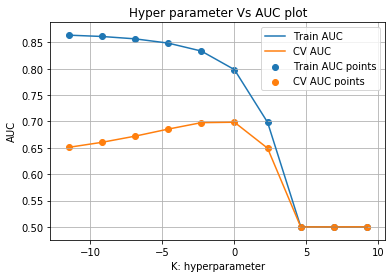

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.196480,0.036180,0.013491,0.003979,1e-05,{'alpha': 1e-05},0.650599,0.659263,0.656040,0.635950,...,0.863538,0.865198,0.862295,0.864795,0.862857,0.864055,0.863999,0.863138,0.863760,0.000823
1,0.183887,0.013205,0.011392,0.001685,0.0001,{'alpha': 0.0001},0.658664,0.669868,0.663485,0.647516,...,0.860914,0.862681,0.859790,0.862310,0.860327,0.861607,0.861494,0.860683,0.861266,0.000831
2,0.180990,0.011088,0.010992,0.001342,0.001,{'alpha': 0.001},0.668896,0.683162,0.672671,0.660815,...,0.856256,0.858107,0.855277,0.857793,0.855781,0.857194,0.856995,0.856268,0.856768,0.000833
3,0.185487,0.020700,0.012592,0.003468,0.01,{'alpha': 0.01},0.680518,0.699056,0.682992,0.676583,...,0.848039,0.849863,0.847179,0.849624,0.847627,0.849304,0.848976,0.848339,0.848697,0.000830
4,0.189085,0.027950,0.011492,0.002905,0.1,{'alpha': 0.1},0.691465,0.713805,0.690361,0.691805,...,0.832815,0.834489,0.832074,0.834307,0.832484,0.834648,0.834005,0.833557,0.833640,0.000840


In [9]:
#Ref https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB

nb=MultinomialNB(fit_prior = True, class_prior = [.5, .5])
parameters = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}
#alpha=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
clf = RandomizedSearchCV(nb, parameters , cv=10, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr, y_train)
results = pd.DataFrame.from_dict(clf.cv_results_)

results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_alpha']
k1=[]
for ele in K:
    k1.append(np.log(ele))
print(K)
print(k1)

plt.plot(k1, train_auc, label='Train AUC')
# Ref https://stackoverflow.com/a/48803361/4084039
plt.plot(k1, cv_auc, label='CV AUC')
plt.scatter(k1, train_auc, label='Train AUC points')
plt.scatter(k1, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

 class 0: Important Feature column name 
['00' '11' '1000' '000' '10th' '100' '100th' '10' '101' '100s' '00pm'
 '105' '108' '10s' '00am' '107' '03' '103' '104' '102']
 class 1: Important Feature column name 
['00' '11' '1000' '10th' '100th' '000' '100' '10' '00pm' '100s' '101'
 '105' '108' '10s' '00am' '107' '03' '103' '102' '104']


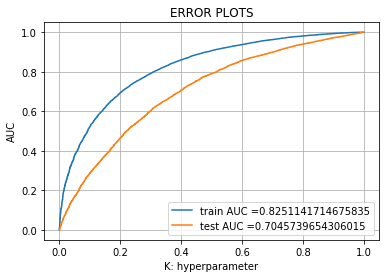

In [10]:
#best alpha =0.1
best_k = 0.1
from sklearn.metrics import roc_curve, auc

def batch_predict(clf, data):
    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    return y_data_pred


nb = MultinomialNB(alpha=best_k,fit_prior = True, class_prior = [.5, .5])
nb.fit(X_tr, y_train)

max_ind_neg=np.argsort((nb.feature_log_prob_)[0][::-1][0:20])
top_neg=np.take(feature_names_bow,max_ind_neg)
print(" class 0: Important Feature column name ")
print(top_neg)

max_ind_pos=np.argsort((nb.feature_log_prob_)[1][::-1][0:20])
top_pos=np.take(feature_names_bow,max_ind_pos)
print(" class 1: Important Feature column name ")
print(top_pos)
        
y_train_pred = batch_predict(nb, X_tr)    
y_test_pred = batch_predict(nb, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [11]:

# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [12]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.5621621950459075 for threshold 0.522
Train confusion matrix
[[ 5592  1834]
 [10548 31067]]
Test confusion matrix
[[ 3213  2246]
 [ 8594 21999]]


### Feature set 2 TFIDF

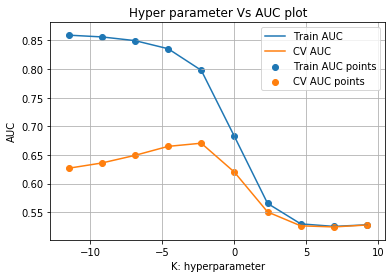

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.200577,0.026954,0.012893,0.001972,1e-05,{'alpha': 1e-05},0.620472,0.636283,0.627882,0.609128,...,0.857875,0.860361,0.858009,0.860966,0.857670,0.859557,0.859043,0.859812,0.859334,0.001092
1,0.200877,0.014646,0.013792,0.002441,0.0001,{'alpha': 0.0001},0.628278,0.647773,0.634912,0.620554,...,0.854607,0.857267,0.854990,0.857894,0.854447,0.856471,0.855952,0.856868,0.856254,0.001155
2,0.209671,0.027382,0.013093,0.003643,0.001,{'alpha': 0.001},0.639535,0.664464,0.644179,0.636906,...,0.847924,0.850731,0.848545,0.851373,0.847721,0.849991,0.849486,0.850698,0.849773,0.001254
3,0.185387,0.013506,0.011793,0.001400,0.01,{'alpha': 0.01},0.654083,0.684329,0.653000,0.656266,...,0.833542,0.836380,0.834335,0.836987,0.833231,0.835995,0.835406,0.837130,0.835616,0.001410
4,0.191083,0.019756,0.011793,0.002134,0.1,{'alpha': 0.1},0.659270,0.691522,0.647638,0.665613,...,0.795788,0.798304,0.796622,0.798403,0.795035,0.798879,0.797784,0.800401,0.797890,0.001639


In [13]:
#Ref https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB

nb=MultinomialNB(fit_prior = True, class_prior = [.5, .5])
parameters = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}
clf = RandomizedSearchCV(nb, parameters, cv=10, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr_tfidf, y_train)
results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc_tfidf= results['mean_train_score']
train_auc_std_tfidf= results['std_train_score']
cv_auc_tfidf = results['mean_test_score'] 
cv_auc_std_tfidf= results['std_test_score']
K =  results['param_alpha']
k1=[]
for ele in K:
    k1.append(np.log(ele))

plt.plot(k1, train_auc_tfidf, label='Train AUC')
# Ref https://stackoverflow.com/a/48803361/4084039
plt.plot(k1, cv_auc_tfidf, label='CV AUC')
plt.scatter(k1, train_auc_tfidf, label='Train AUC points')
plt.scatter(k1, cv_auc_tfidf, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

### Feature set 2 TFIDF

 class 0: Important Feature column name 
['00' '11' '1000' '000' '10th' '100' '100th' '10' '101' '100s' '00pm'
 '105' '108' '10s' '00am' '107' '03' '103' '104' '102']
 class 1: Important Feature column name 
['00' '11' '1000' '10th' '100th' '000' '100' '10' '00pm' '100s' '101'
 '105' '108' '10s' '00am' '107' '03' '103' '102' '104']


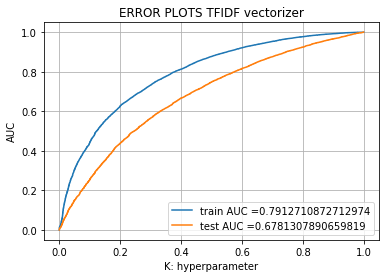

In [14]:
#best alpha =0.1
best_k_tfidf = 0.1
from sklearn.metrics import roc_curve, auc

def batch_predict(clf, data):
    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    return y_data_pred


nb = MultinomialNB(alpha=best_k_tfidf,fit_prior = True, class_prior = [.5, .5])
nb.fit(X_tr_tfidf, y_train)

max_ind_neg_tfidf=np.argsort((nb.feature_log_prob_)[0][::-1][0:20])
top_neg_tfidf=np.take(feature_names_tfidf,max_ind_neg_tfidf)
print(" class 0: Important Feature column name ")
print(top_neg_tfidf)

max_ind_pos_tfidf=np.argsort((nb.feature_log_prob_)[1][::-1][0:20])
top_pos_tfidf=np.take(feature_names_tfidf,max_ind_pos_tfidf)
print(" class 1: Important Feature column name ")
print(top_pos_tfidf)

y_train_pred = batch_predict(nb, X_tr_tfidf)    
y_test_pred = batch_predict(nb, X_te_tfidf)

train_fpr_tfidf, train_tpr_tfidf, tr_thresholds_tfidf = roc_curve(y_train, y_train_pred)
test_fpr_tfidf, test_tpr_tfidf, te_thresholds_tfidf = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr_tfidf, train_tpr_tfidf, label="train AUC ="+str(auc(train_fpr_tfidf, train_tpr_tfidf)))
plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS TFIDF vectorizer")
plt.grid()
plt.show()

### Feature set 2 TFIDF

In [15]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t_tfidf = find_best_threshold(tr_thresholds_tfidf, train_fpr_tfidf, train_tpr_tfidf)
print("Train confusion matrix TFIDF vectorizer")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t_tfidf)))
print("Test confusion matrix TFIDF Vextorizer")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t_tfidf)))

the maximum value of tpr*(1-fpr) 0.5136970489784926 for threshold 0.5
Train confusion matrix TFIDF vectorizer
[[ 5289  2137]
 [11600 30015]]
Test confusion matrix TFIDF Vextorizer
[[ 3119  2340]
 [ 9544 21049]]


<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [16]:
#Ref http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper parameter","AUC"]

for i in range(1):
    x.add_row(["BOW","Brute force", best_k, auc(test_fpr, test_tpr)])

for i in range(1):
    x.add_row(["TFIDF","Brute force", best_k_tfidf, auc(test_fpr_tfidf, test_tpr_tfidf)])
print(x)


+------------+-------------+-----------------+--------------------+
| Vectorizer |    Model    | Hyper parameter |        AUC         |
+------------+-------------+-----------------+--------------------+
|    BOW     | Brute force |       0.1       | 0.7045739654306015 |
|   TFIDF    | Brute force |       0.1       | 0.6781307890659819 |
+------------+-------------+-----------------+--------------------+
